In [19]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score


In [20]:
RANDOM_STATE = 1
df = pd.read_csv("../data/clean_train.csv")
df.head(3)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,cabin_deck,solo
0,0,lower,"braund,_mr._owen_harris",male,22.0,1,0,a/5_21171,7.2500,unknown,s,u,0
1,1,upper,"cumings,_mrs._john_bradley_(florence_briggs_th...",female,38.0,1,0,pc_17599,71.2833,c85,c,c,0
2,1,lower,"heikkinen,_miss._laina",female,26.0,0,0,ston/o2._3101282,7.9250,unknown,s,u,1


In [21]:
numerical_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked', 'cabin_deck', 'solo']

In [22]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

y_train = df_train['survived'].values
y_val = df_val['survived'].values

del df_train['survived']
del df_val['survived']

In [23]:
dicts = df_train[numerical_features + categorical_features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

dicts = df_val[numerical_features + categorical_features].to_dict(orient='records')
X_val = dv.transform(dicts)


In [24]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [40]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]
model = xgb.train(xgb_params, dtrain, num_boost_round=200)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)


0.8281855776686482

In [41]:
def xgb_tunning(param_name, param_values, xgb_params=xgb_params):
    scores = {} # dictionary to store results for each eta

    for param_value in param_values:
        evals_result = {}
        xgb_params = xgb_params.copy()
        xgb_params[param_name] = param_value
    
        model = xgb.train(
            xgb_params,
            dtrain,
            evals=watchlist,
            verbose_eval=0,
            num_boost_round=200,
            evals_result=evals_result
        )

        columns = ['iter', 'train_auc', 'val_auc']
        train_aucs = list(evals_result['train'].values())[0]
        val_aucs = list(evals_result['val'].values())[0]

        df_results = pd.DataFrame(
            list(zip(range(1, len(train_aucs) + 1), train_aucs, val_aucs)),
            columns=columns
        )

        key = f'{param_name}={param_value}'
        scores[key] = df_results
    return scores


In [42]:
scores = xgb_tunning(param_name='eta', param_values=np.linspace(0.01, 0.5, 51))
scores['eta=0.01']

,iter,train_auc,val_auc
0,1,0.657766,0.673695
1,2,0.652660,0.669530
2,3,0.647659,0.665456
3,4,0.642762,0.661449
4,5,0.637947,0.657594
...,...,...,...
195,196,0.328993,0.467005
196,197,0.328436,0.466984
197,198,0.327789,0.467131
198,199,0.327396,0.467076


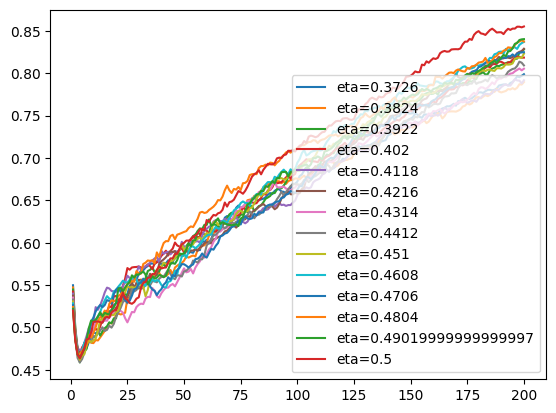

In [45]:
for eta, df_score in scores.items():
    if df_score['val_auc'].mean() > 0.65:
        plt.plot(df_score.iter, df_score.val_auc, label=eta)

plt.legend()

In [47]:
xgb_params['eta'] = 0.5

In [48]:
scores = xgb_tunning(param_name='max_depth', param_values=[x for x in range(1, 31, 3)])

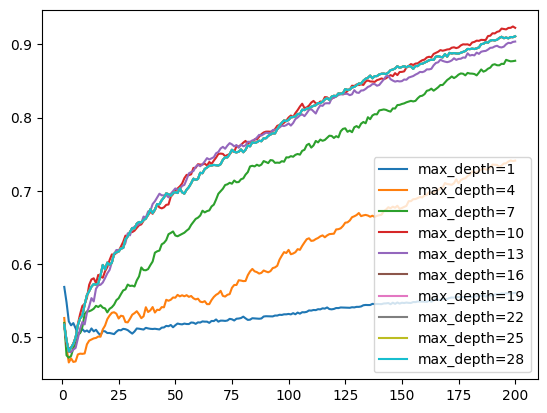

In [49]:
for depth, df_score in scores.items():
    plt.plot(df_score.iter, df_score.val_auc, label=depth)

plt.legend()

In [50]:
xgb_params['max_depth'] = 10

In [51]:
scores = xgb_tunning(param_name='min_child_weight', param_values=[x for x in range(1, 15, 2)])

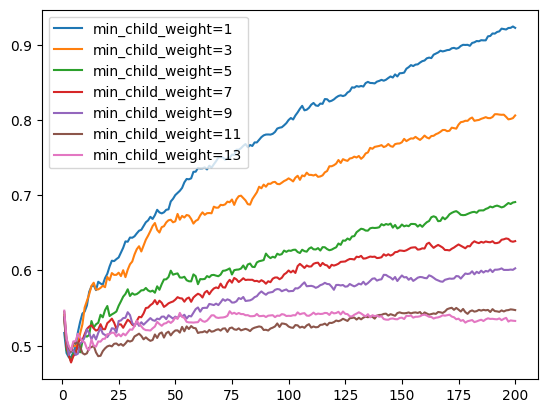

In [52]:
for w, df_score in scores.items():
    plt.plot(df_score.iter, df_score.val_auc, label=w)
plt.legend()

In [53]:
xgb_params['min_child_weight'] = 1

In [54]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8288963556474541